In [1]:
from os.path import exists
from subprocess import run, PIPE
import nibabel as nib
import numpy as np
from nilearn import image, plotting

In [2]:
# Pick a Narratives representative subject for now
subject = 'sub-050'
task = 'pieman'
grid = '3.0mm'

# Filenames for the whole-brain MNI mask and resampled version
brain_fn = 'space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
mask_fn = f'space-MNI152NLin2009cAsym_desc-brain{grid}_mask.nii.gz'

# Filename for BOLD data
bold_fn = f'{subject}_task-{task}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [3]:
# Resample the mask to match BOLD grid
if not exists(mask_fn):
    print("Resample brain mask to BOLD grid")
    run(f"3dresample -master {bold_fn} -prefix {mask_fn} "
        f"-input {brain_fn} -rmode NN", shell=True);

In [4]:
# Check the voxel dimensions of the BOLD image and mask
bold_shape = nib.load(bold_fn).shape[:3]
n_trs = nib.load(bold_fn).shape[-1]
print(f"BOLD shape: {bold_shape}")
print(f"Number of TRs: {n_trs}")
print(f"BOLD resolution: {nib.load(bold_fn).header.get_zooms()[:3]}")
print(f"mask resolution: {nib.load(mask_fn).header.get_zooms()[:3]}")

BOLD shape: (65, 77, 49)
Number of TRs: 300
BOLD resolution: (3.0, 3.0, 4.0)
mask resolution: (3.0, 3.0, 4.0)


In [5]:
# Estimate FWHM from the original data
orig_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {bold_fn} "
                "-detrend -acf NULL -ShowMeClassicFWHM",
                shell=True, stdout=PIPE)
print("FWHM (native):", orig_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (native):  2.9519  3.21721  3.81454     3.30883


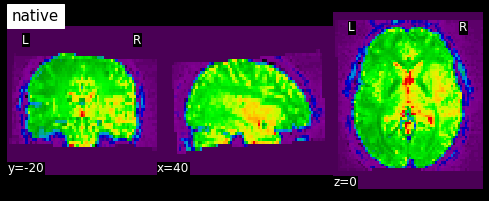

In [6]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(bold_fn, t),
                  cut_coords=coords, title='native', 
                  draw_cross=False, annotate='False');

In [7]:
# Try 3dmerge classic smoothing (with no mask)
width = 4.0
merge_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
            f'_desc-3dmerge{width}_bold.nii.gz')

run(f"3dmerge -1blur_fwhm {width} -doall "
    f"-prefix {merge_fn} {bold_fn}", shell=True);

In [8]:
# Check FWHM after 3dmerge with 6 mm kernel
merge_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {merge_fn} "
                 "-detrend -acf NULL -ShowMeClassicFWHM",
                 shell=True, stdout=PIPE)
print(f"FWHM (after 3dmerge with {width} mm kernel):\n",
      merge_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dmerge with 4.0 mm kernel):
  5.81018  5.91799  6.03092     5.91901


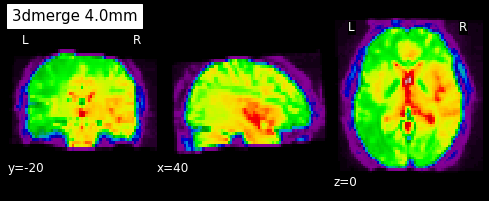

In [9]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(merge_fn, t),
                  cut_coords=coords,
                  title=f'3dmerge {width}mm',
                  draw_cross=False, annotate='False');

In [10]:
# Try 3dBlurInMask smoothing
width = 5.0
blurinmask_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
                 f'_desc-3dBlurInMask{width}_bold.nii.gz')

run(f"3dBlurInMask -FWHM {width} -mask {mask_fn} "
    f"-input {bold_fn} -prefix {blurinmask_fn}", shell=True);

In [11]:
# Check FWHM after 3dBlurInMask
blurinmask_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {blurinmask_fn} "
                      "-detrend -acf NULL -ShowMeClassicFWHM",
                      shell=True, stdout=PIPE)
print(f"FWHM (after 3dBlurInMask with {width} mm kernel):\n",
      blurinmask_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dBlurInMask with 5.0 mm kernel):
  5.86561  6.09081  6.29519     6.08134


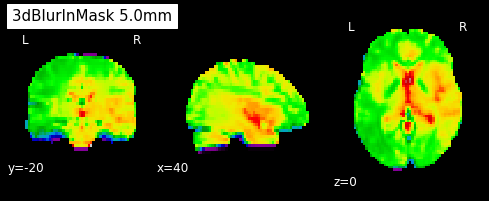

In [12]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(blurinmask_fn, t),
                  cut_coords=coords,
                  title=f'3dBlurInMask {width}mm',
                  draw_cross=False, annotate='False');

In [13]:
# Try 3dBlurToFWHM with 6 mm target smoothness
smoothness = 6.0
blurtofwhm_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
                 f'_desc-3dBlurToFWHM{smoothness}_bold.nii.gz')

run(f"3dBlurToFWHM -mask {mask_fn} -FWHM {smoothness} "
    f"-input {bold_fn} -prefix {blurtofwhm_fn}", shell=True);

In [14]:
# Check FWHM after 3dBlurToFWHM (should roughly match)
blurtofwhm_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {blurtofwhm_fn} "
                      "-detrend -acf NULL -ShowMeClassicFWHM",
                      shell=True, stdout=PIPE)
print(f"FWHM (after 3dBlurToFWHM with {smoothness} mm target smoothness):\n",
      blurtofwhm_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dBlurToFWHM with 6.0 mm target smoothness):
  5.7487  5.81199  6.30655     5.95062


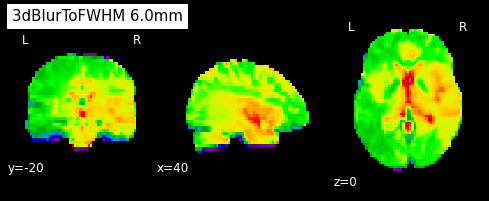

In [15]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(blurtofwhm_fn, t),
                  cut_coords=coords,
                  title=f'3dBlurToFWHM {smoothness}mm',
                  draw_cross=False, annotate='False');